In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [29]:
fpath = 'facebook_data_CNN_post_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,WNPositive,WNNegative,WNNeutral,WNSentiment,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,1,10162001067901509,2021-05-16 18:33:17,"""If we can't as an international community pre...",159,0,2.375,3.250,16.375,-0.875,...,29,0.068966,0,4,29,-0.137931,0.112,0.073,0.815,0.2960
1,2,10162000992086509,2021-05-16 18:01:11,In a sign of the Biden administration's embrac...,389,20,0.875,0.000,18.125,0.875,...,25,0.000000,1,0,25,0.040000,0.117,0.060,0.823,0.6249
2,3,10162000989931509,2021-05-16 18:00:31,What’s your favorite David Letterman bit? Hear...,59,0,0.625,0.500,13.875,0.125,...,20,0.000000,2,1,20,0.050000,0.142,0.000,0.858,0.5859
3,4,10162000949151509,2021-05-16 17:41:09,"""The Republican Party's decision, in effect, t...",315,0,1.000,0.500,10.500,0.500,...,21,0.047619,1,0,21,0.047619,0.062,0.000,0.938,0.4019
4,5,10162000877181509,2021-05-16 17:00:52,"A group of more than 150 Republicans, led by D...",534,176,1.000,0.375,20.625,0.625,...,28,0.000000,0,2,28,-0.071429,0.049,0.065,0.886,0.0258


In [3]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

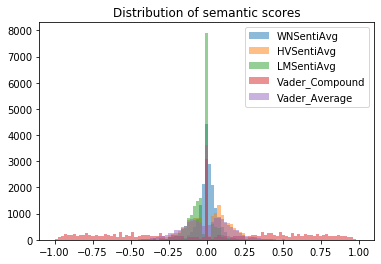

In [4]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

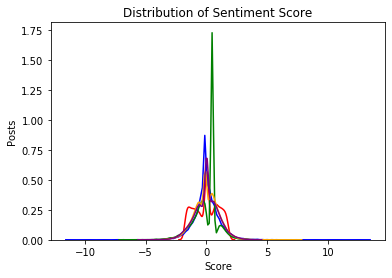

In [5]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [6]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,18092.000000,18092.000000,18092.000000,18092.000000,18092.000000
mean,0.009066,0.014156,-0.033750,-0.012064,-0.001990
std,0.056288,0.132874,0.071679,0.536233,0.143122
min,-0.625000,-0.666667,-0.526316,-0.989800,-0.750000
25%,-0.017094,-0.071429,-0.071429,-0.476700,-0.091000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.037500,0.100000,0.000000,0.421500,0.087000
max,0.750000,1.000000,0.500000,0.989200,0.590000


In [7]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [8]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [9]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'Text', 'Likes', 'Shares', 'WNPositive',
       'WNNegative', 'WNNeutral', 'WNSentiment', 'WNTokenQnt', 'WNSentiAvg',
       'HVPositive', 'HVNegative', 'HVTokenQnt', 'HVSentiAvg', 'LMPositive',
       'LMNegative', 'LMTokenQnt', 'LMSentiAvg', 'Vader_Positive',
       'Vader_Negative', 'Vader_Neutral', 'Vader_Compound', 'Vader_Average',
       'DateMonth', 'DateDay'],
      dtype='object')

In [10]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [11]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [12]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [13]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -47.7633
p-value                           0.0000
#Lags Used                        0.0000
Number of Observations Used    2449.0000
Critical Value (1%)              -3.4330
Critical Value (5%)              -2.8627
Critical Value (10%)             -2.5674
dtype: float64


In [14]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -10.8040
p-value                           0.0000
#Lags Used                       13.0000
Number of Observations Used    2436.0000
Critical Value (1%)              -3.4330
Critical Value (5%)              -2.8627
Critical Value (10%)             -2.5674
dtype: float64


In [15]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                  -10.8040
p-value                           0.0000
#Lags Used                       13.0000
Number of Observations Used    2436.0000
Critical Value (1%)              -3.4330
Critical Value (5%)              -2.8627
Critical Value (10%)             -2.5674
dtype: float64
Results of Dickey-Fuller Test:


In [16]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -7.8225
p-value                           0.0000
#Lags Used                       16.0000
Number of Observations Used    2433.0000
Critical Value (1%)              -3.4330
Critical Value (5%)              -2.8627
Critical Value (10%)             -2.5674
dtype: float64
Results of Dickey-Fuller Test:


In [17]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2010-08-23,0.131250,2,0.550800,0.165500,8,2,57,1,3,57,0.065625,0.105263,-0.035088
2010-08-24,0.033488,3,0.128733,0.014667,8,10,74,0,10,74,0.011163,-0.027027,-0.135135
2010-08-25,0.007167,3,-0.359700,-0.085333,6,8,71,1,3,71,0.002389,-0.028169,-0.028169
2010-08-26,-0.005411,3,-0.142767,-0.071333,8,11,84,0,7,84,-0.001804,-0.035714,-0.083333
2010-08-27,0.068984,3,-0.205667,-0.029333,6,4,89,0,6,89,0.022995,0.022472,-0.067416


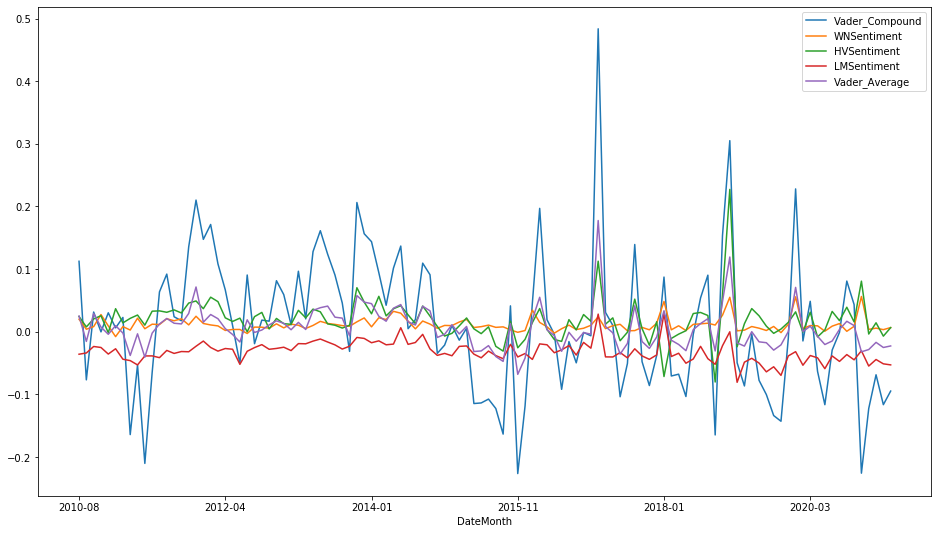

In [30]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [19]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2009','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2009','05/01/2021',interval='m')

In [20]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [21]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [22]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [23]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [24]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [25]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [26]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [27]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2010-08,1129.239990,1039.699951,1107.530029,1049.329956,85738250000,1049.329956,-0.048612,0.481797,24,0.112521,0.025042,62,47,614,8,30,614,0.020075,0.024430,-0.035831
2010-09,1157.160034,1049.719971,1049.719971,1141.199951,79589450000,1141.199951,0.083928,0.245800,61,-0.076744,-0.015410,184,170,1802,21,82,1802,0.004030,0.007769,-0.033851
2010-10,1196.140015,1131.869995,1143.489990,1183.260010,89536270000,1183.260010,0.036193,0.592044,72,0.031511,0.029139,213,171,2044,26,74,2044,0.008223,0.020548,-0.023483
2010-11,1227.079956,1173.000000,1185.709961,1180.550049,87151070000,1180.550049,-0.002293,1.815952,66,-0.000118,0.007515,190,145,1755,29,73,1755,0.027514,0.025641,-0.025071
2010-12,1262.599976,1186.599976,1186.599976,1257.640015,80984530000,1257.640015,0.063256,0.516736,55,0.030304,-0.004000,126,128,1321,18,65,1321,0.009395,-0.001514,-0.035579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,0.281670,5,-0.225740,-0.032000,17,9,99,2,5,99,0.056334,0.080808,-0.030303
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,0.908388,243,-0.122481,-0.028366,636,655,5281,69,358,5281,0.003738,-0.003598,-0.054724
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,3.460631,596,-0.068645,-0.016913,1703,1517,12965,184,758,12965,0.005806,0.014346,-0.044273
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,1.794233,525,-0.116374,-0.025088,1272,1350,11195,143,716,11195,0.003418,-0.006967,-0.051184


In [28]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var], Granger_data_daily['LogReturn'])


Vader_Compound



C:\Users\Windows\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


Optimal number of lags for exog data is 7
Optimal number of lags for endog data is 3

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0008  , p=0.9771  , df_denom=1724, df_num=1
ssr based chi2 test:   chi2=0.0008  , p=0.9771  , df=1
likelihood ratio test: chi2=0.0008  , p=0.9771  , df=1
parameter F test:         F=0.0008  , p=0.9771  , df_denom=1724, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1419  , p=0.8677  , df_denom=1721, df_num=2
ssr based chi2 test:   chi2=0.2846  , p=0.8674  , df=2
likelihood ratio test: chi2=0.2845  , p=0.8674  , df=2
parameter F test:         F=0.1419  , p=0.8677  , df_denom=1721, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5561  , p=0.6441  , df_denom=1718, df_num=3
ssr based chi2 test:   chi2=1.6751  , p=0.6425  , df=3
likelihood ratio test: chi2=1.6742  , p=0.6427  , df=3
parameter F test:         F=0.55

Optimal number of lags for exog data is 2
Optimal number of lags for endog data is 3

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9887  , df_denom=1724, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9887  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9887  , df=1
parameter F test:         F=0.0002  , p=0.9887  , df_denom=1724, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4823  , p=0.6175  , df_denom=1721, df_num=2
ssr based chi2 test:   chi2=0.9674  , p=0.6165  , df=2
likelihood ratio test: chi2=0.9671  , p=0.6166  , df=2
parameter F test:         F=0.4823  , p=0.6175  , df_denom=1721, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8145  , p=0.4858  , df_denom=1718, df_num=3
ssr based chi2 test:   chi2=2.4536  , p=0.4837  , df=3
likelihood ratio test: chi2=2.4518  , p=0.4841  , df=3
parameter F test:         F=0.81

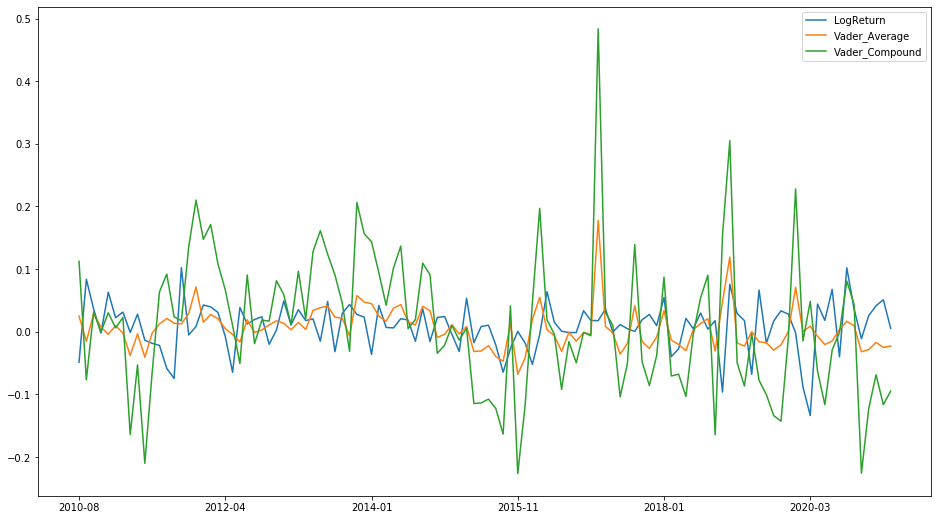

In [31]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [34]:
corr = Granger_data_daily[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average', 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Flair_Score,SentimentScoreAdj,Vader_Average,LogReturn
Vader_Compound,1.000000,0.237375,0.421607,0.904405,0.024251
Flair_Score,0.237375,1.000000,0.126345,0.236614,0.024030
SentimentScoreAdj,0.421607,0.126345,1.000000,0.378771,0.019746
Vader_Average,0.904405,0.236614,0.378771,1.000000,0.023152
LogReturn,0.024251,0.024030,0.019746,0.023152,1.000000


In [32]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
#print(corr_signif.to_latex())
print(corr_signif)

                 p-value
Vader_Compound  0.284267
Vader_Average   0.509465
WNSentiment     0.765113
HVSentiment     0.199683
LMSentiment     0.226205


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
